In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("./data/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")

In [3]:
data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend
0,10,2) $100 - $200,142.44,1,0,Surburban,0,Phone,Womens E-Mail,0,0,0.0
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0
2,7,2) $100 - $200,180.65,0,1,Surburban,1,Web,Womens E-Mail,0,0,0.0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0
4,2,1) $0 - $100,45.34,1,0,Urban,0,Web,Womens E-Mail,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
63995,10,2) $100 - $200,105.54,1,0,Urban,0,Web,Mens E-Mail,0,0,0.0
63996,5,1) $0 - $100,38.91,0,1,Urban,1,Phone,Mens E-Mail,0,0,0.0
63997,6,1) $0 - $100,29.99,1,0,Urban,1,Phone,Mens E-Mail,0,0,0.0
63998,1,5) $500 - $750,552.94,1,0,Surburban,1,Multichannel,Womens E-Mail,0,0,0.0


In [4]:
male_df = data[data['segment'] != 'Womens E-Mail']
male_df.shape


(42613, 12)

In [5]:
male_df['treatment'] = male_df['segment'].map(lambda x: 1 if x == 'Mens E-Mail' else 0)
male_df.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
1,6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0.0,0
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1


In [6]:
# バイアスのあるデータの準備
treatment_data = male_df[male_df['treatment'] == 1]
control_data = male_df[male_df['treatment'] == 0]

treatment_biased = treatment_data.drop(treatment_data[~(
    (treatment_data['history'] > 300) |
    (treatment_data['recency'] < 6) |
    (treatment_data['recency'] == 'Multichannel')
)].sample(frac=0.5, random_state=1).index)

control_biased = control_data.drop(control_data[
    (control_data['history'] > 300) |
    (control_data['recency'] < 6) |
    (control_data['recency'] == 'Multichannel')
].sample(frac=0.5, random_state=1).index)

biased_data = pd.concat([treatment_biased, control_biased])
biased_data.head(3)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
3,9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0.0,1
8,9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0.0,1
13,2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0.0,1


In [7]:
import numpy as np
struct_data = biased_data.copy()

non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['history_segment', 'zip_code', 'channel', 'segment']


In [8]:

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
3,9,4,675.83,1,0,0,1,2,0,0,0,0.0,1
8,9,4,675.07,1,1,0,1,1,0,0,0,0.0,1
13,2,1,101.64,0,1,2,0,2,0,1,0,0.0,1
16,5,0,29.99,1,0,1,0,1,0,0,0,0.0,1
17,9,1,112.35,1,0,0,0,2,0,0,0,0.0,1


<AxesSubplot:>

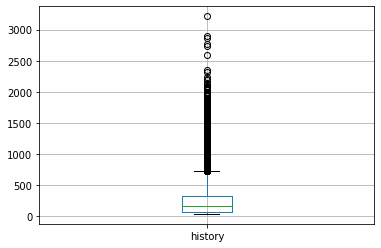

In [9]:
struct_data[["history"]].boxplot()

In [10]:
from causalnex.discretiser import Discretiser
struct_data["spend"] = Discretiser(method="fixed",
                          numeric_split_points=[100, 200, 300, 400, 500]).transform(struct_data["spend"].values)

struct_data["history"] = Discretiser(method="fixed",
                          numeric_split_points=[0, 1000, 2000, 3000, 4000]).transform(struct_data["history"].values)

In [11]:
struct_data

,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment
3,9,4,1,1,0,0,1,2,0,0,0,0,1
8,9,4,1,1,1,0,1,1,0,0,0,0,1
13,2,1,1,0,1,2,0,2,0,1,0,0,1
16,5,0,1,1,0,1,0,1,0,0,0,0,1
17,9,1,1,1,0,0,0,2,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63977,8,0,1,0,1,1,0,2,1,1,0,0,0
63979,10,1,1,0,1,1,0,1,1,0,0,0,0
63980,3,3,1,0,1,1,1,1,1,0,0,0,0
63987,1,0,1,1,0,1,1,2,1,0,0,0,0


<AxesSubplot:>

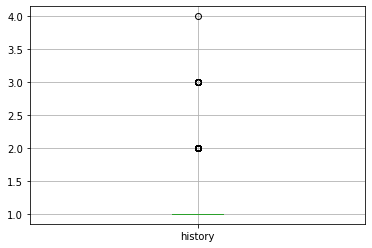

In [12]:
struct_data[["history"]].boxplot()

In [13]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(struct_data)

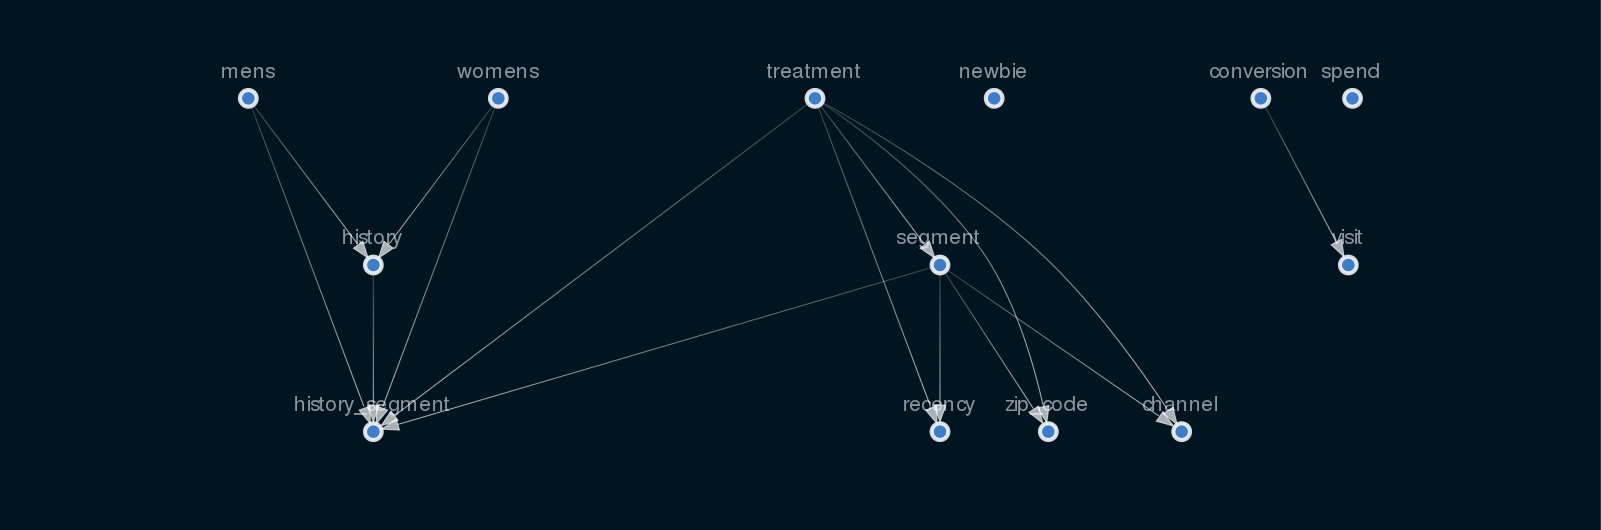

In [14]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
sm.remove_edges_below_threshold(0.8)

custom_style = NODE_STYLE.WEAK
custom_style["fontsize"] = 5
custom_stylecustom_style = NODE_STYLE.WEAK
custom_style["fontsize"] = 5
custom_style

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=custom_style,
    all_edge_attributes=EDGE_STYLE.WEAK,
    prog="dot")
Image(viz.draw(format='png'))